# Chapter 0: Feature engineering and processing
So apparently, I named this filed `preprocessing.ipynb` way before I started writing the readme. A good software engineer would have changed the name of the file to keep all terminology consistent.

I am not a software engineer.

We start with importing stuff, as usual.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, shutil

import spacy
from collections import Counter

from imblearn.over_sampling import RandomOverSampler

I downloaded the data from [here](https://www.kaggle.com/datasets/thesumitbanik/covid-fake-news-dataset) to my local machine. Not gonna lie, I was a bit disappointed that the dataset was so small. I was hoping for a bit more. Not going to upload the data to github, diy you lazy bum.

In [40]:
DATA_SOURCE = 'data/covid.zip'

This dataset is really basic. Like ordering matcha latte frap with 2 shots of whipped cream basic. It literally has like one column for the text and one column for the label. I am not sure how I am going to do this, but I am going to try to make this as interesting as possible.

In [41]:
df = pd.read_csv(DATA_SOURCE)
df.head()

,headlines,outcome
0,A post claims compulsory vacination violates t...,0
1,A photo claims that this person is a doctor wh...,0
2,Post about a video claims that it is a protest...,0
3,All deaths by respiratory failure and pneumoni...,0
4,The dean of the College of Biologists of Euska...,0


In the age of transformers, we can very easily slap this data into a model and get some results. But, that would be no fun isn't it? So let's see what kinds of features we can extract from this a chunk of text and see if we can combine these features with a transformer model to get better results.

## Part 1: Feature engineering

I guess you can do something like BoW or TF-IDF. I am not going to do that, and here is why: *I'm lazy*. 

But I do want some tabular features we can use to train a model in tandem with some text you can just throw into a transformer model. So let's see what we can do.

### Add feature that counts the number of words in each headlines

In [42]:
def plot_hist_by_outcome(df, col, bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    axes[0].hist(df[df['outcome'] == 0][col], bins=bins)
    axes[1].hist(df[df['outcome'] == 1][col], bins=bins)
    # subplots share the same x-axis range, and the y-axis range is automatically adjusted
    axes[0].set_title('Fake News')
    axes[1].set_title('Real News')
    fig.suptitle(col)
    
    plt.show()



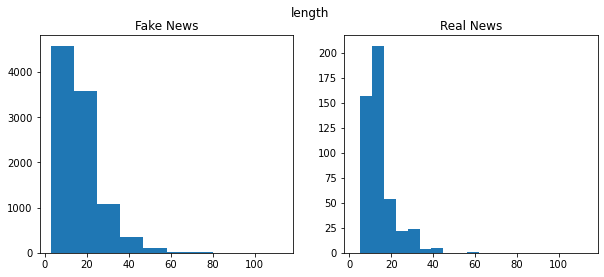

In [43]:
df['length'] = df['headlines'].apply(lambda x: len(x.split()))
plot_hist_by_outcome(df, 'length', bins=10)

We can see that real news tend to be slightly shorter in words. This could be fake new feels insecure about itself and tries to compensate by using more words, bigger words, more difficulter words. Or it could be that real news are more concise and to the point. I don't know, I am not a journalist.

### Add boolean feature that indicate if headline included statistics

In [44]:
def bar_chart_by_col(df, col):
    # count % of col values in each outcome
    df = df.groupby([col, 'outcome']).count().reset_index().pivot(index=col, columns='outcome', values='headlines')
    df = df.div(df.sum(axis=1), axis=0) * 100
    df.plot.bar(figsize=(8, 4))
    plt.title('% of fake news in each {} value'.format(col))

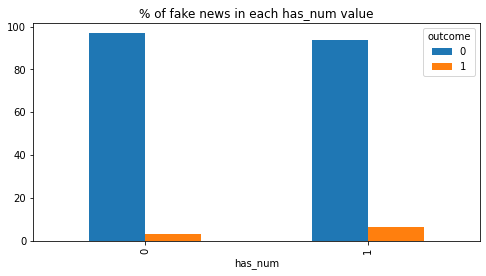

In [45]:
df['has_num'] = df['headlines'].str.contains(r'\d', regex=True).astype(int)
bar_chart_by_col(df, 'has_num')

Seems like headlines with statistics turns out to be more likely real news. Which is surprising, who would have thought that fake news would be so bad at math.

### Add categorical features with Name-Entity Recognition using SpaCy and extract count of each entity labels

You know what, I caved and decided to use one of those classic era NLP stuff. One of the cool thing we can do is to use Name-Entity Recognition (NER) to extract entities from the text. It basically looks for liek proper nouns like names, locations or organizations. We can then count these entities as features. I am using SpaCy for this, because it is easy to use and I am lazy.

In [46]:
nlp = spacy.load('en_core_web_sm')

# @np.vectorize
def ner(text):
    doc = nlp(text)
    labels = [X.label_ for X in doc.ents]
    return Counter(labels)

df['ner'] = df['headlines'].apply(ner)
df.head()

,headlines,outcome,length,has_num,ner
0,A post claims compulsory vacination violates t...,0,30,1,{'ORG': 2}
1,A photo claims that this person is a doctor wh...,0,24,1,"{'ORG': 1, 'FAC': 1, 'GPE': 1}"
2,Post about a video claims that it is a protest...,0,20,0,{'ORG': 1}
3,All deaths by respiratory failure and pneumoni...,0,18,1,{'ORG': 2}
4,The dean of the College of Biologists of Euska...,0,24,0,{'ORG': 2}


In [47]:
labels = [list(c.keys()) for c in df.ner.values]
labels = set([item for sublist in labels for item in sublist])

for label in labels:
    df['ner_' + label.lower()] = df['ner'].apply(lambda x: x.get(label, 0))
df = df.drop(columns=['ner'])
df.head()




,headlines,outcome,length,has_num,ner_norp,ner_cardinal,ner_gpe,ner_date,ner_language,ner_percent,...,ner_money,ner_loc,ner_ordinal,ner_product,ner_org,ner_person,ner_fac,ner_time,ner_work_of_art,ner_quantity
0,A post claims compulsory vacination violates t...,0,30,1,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1,A photo claims that this person is a doctor wh...,0,24,1,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,Post about a video claims that it is a protest...,0,20,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,All deaths by respiratory failure and pneumoni...,0,18,1,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
4,The dean of the College of Biologists of Euska...,0,24,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


## Part 2: Class imbalance
One of the biggest challenges with modeling is rare events. If one of the classes we try to predict is very scarce in the data, it makes the model pretty biased even if the dataset is huge. With that in mind, let's do a quick count of the number of examples in each class.

In [48]:
def plot_count_of_each_outcome(df):
    df.groupby('outcome').count().headlines.plot.bar(figsize=(4, 4))
    plt.title('Number of news headlines in each outcome')

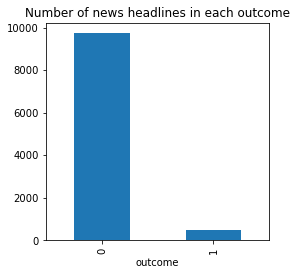

In [49]:
plot_count_of_each_outcome(df)

Oof! Very imbalanced. This tend to result in model having severe bias towards the majority class. While this is an accurate reflection about society, I can't help but to wonder: how do we have so many liars in news? We will need to do something about this. I mean I have no control over the media, but what I can do is to oversample the minority class. 

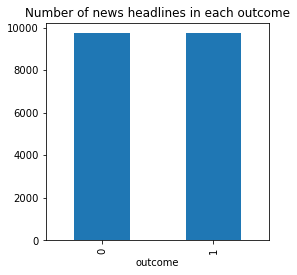

In [50]:
X = df.drop(columns=['outcome'])
y = df['outcome']

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X, y = ros.fit_resample(X, y)

df = pd.concat([X, y], axis=1)
plot_count_of_each_outcome(df)

`# TODO: Insert thanos perfectly balanced meme`

## Part 3: Distribute dataset and save to the ☁️☁️
The dataset is pretty small, we could have easily load the whole thing in memory and train on it. However, as I've asked before, what is the fun in that? 

One of the cool things we can do to a dataset is that we don't need to keep it as a single file. We can split it into multiple files and save it to the cloud. This is useful because we can then load the data in parallel and train on it. Image we have a big ass dataset instead, there will be quite a huge problem if the dataset becomes too big to be fully loaded into memory. By spliting the files up, we can allow data to be trained in batches, and only a single batch of data is loaded each weight update.

In [51]:
int_cols = list(df.columns)
int_cols.remove('headlines')
df[int_cols] = df[int_cols].astype(np.int16)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19454 entries, 0 to 19453
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   headlines        19454 non-null  object
 1   length           19454 non-null  int16 
 2   has_num          19454 non-null  int16 
 3   ner_norp         19454 non-null  int16 
 4   ner_cardinal     19454 non-null  int16 
 5   ner_gpe          19454 non-null  int16 
 6   ner_date         19454 non-null  int16 
 7   ner_language     19454 non-null  int16 
 8   ner_percent      19454 non-null  int16 
 9   ner_event        19454 non-null  int16 
 10  ner_law          19454 non-null  int16 
 11  ner_money        19454 non-null  int16 
 12  ner_loc          19454 non-null  int16 
 13  ner_ordinal      19454 non-null  int16 
 14  ner_product      19454 non-null  int16 
 15  ner_org          19454 non-null  int16 
 16  ner_person       19454 non-null  int16 
 17  ner_fac          19454 non-null

In [52]:
BATCH_SIZE = 16
BUCKET_NAME = 'xy-mp-pipeline'
OUTPUT_PATH = 'data/covid-csv'

Here, we want to split the data into train and test and store them in different directories, then within each folder, we save a file containing 32 examples each.

In [53]:
def train_test_split(df: pd.DataFrame, test_size: float=0.2):
    '''Split the dataframe into train and test sets, stratified by outcome'''
    positive = df[df['outcome'] == 1]
    negative = df[df['outcome'] == 0]

    n_pos = len(positive)
    n_neg = len(negative)

    negative_test = negative.iloc[:int(n_neg * test_size)]
    negative_train = negative.iloc[int(n_neg * test_size):]
    positive_test = positive.iloc[:int(n_pos * test_size)]
    positive_train = positive.iloc[int(n_pos * test_size):]

    train_df = pd.concat([positive_train, negative_train])
    test_df = pd.concat([positive_test, negative_test])
    return train_df, test_df

def write_csvs(df: pd.DataFrame, folder: str, output_path: str, batch_size: int):
    '''Write the dataframe into multiple csv files, each with batch_size rows'''
    if not os.path.exists(output_path + '/' + folder):
        os.makedirs(output_path + '/' + folder)

    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch.to_csv(f'{output_path}/{folder}/file{i}.csv', index=False)

# make sure you have the aws cli installed and configured when you run this function
def write_files_to_s3(output_path: str, bucket_name: str):
    !aws s3 rm --recursive s3://$bucket_name/$output_path
    !aws s3 cp --recursive $output_path s3://$bucket_name/$output_path

In [54]:
train_df, test_df = train_test_split(df)
train_len, test_len = len(train_df), len(test_df)

shutil.rmtree(OUTPUT_PATH, ignore_errors=True)
write_csvs(train_df, 'training', OUTPUT_PATH, BATCH_SIZE)
write_csvs(test_df, 'testing', OUTPUT_PATH, BATCH_SIZE)

write_files_to_s3(OUTPUT_PATH, BUCKET_NAME)

delete: s3://xy-mp-pipeline/data/covid-csv/testing/file1.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file0.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file13.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file15.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file12.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file11.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file10.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file17.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file18.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file19.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file3.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file14.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file16.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file5.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file4.csv
delete: s3://xy-mp-pipeline/data/covid-csv/testing/file2.csv
delete: s3://x

### Save a copy of table schema to help us in the future

One of the issues with your data being **all over the place** is that it's hard to do some basic information retrival. How many rows are there in these 400+ files? Who the heck knows?

In [55]:
from pandas.io.json._table_schema import build_table_schema

schema = build_table_schema(df)['fields']
schema.pop(0)
label = schema.pop(schema.index({'name': 'outcome', 'type': 'integer'}))
schema = {
    'input_features': {data['name']: data['type'] for data in schema},
    'output_features': {'outcome': label['type']}
}
metadata = {
    'name': 'Covid News Headlines',
    'version': '1.0',
    'dataset_size': len(df),
    'batch_size': BATCH_SIZE,
    'train_size': train_len,
    'test_size': test_len,
    'schema': schema
}


In [56]:
metadata

{'name': 'Covid News Headlines',
 'version': '1.0',
 'dataset_size': 200,
 'batch_size': 2,
 'train_size': 160,
 'test_size': 40,
 'schema': {'input_features': {'headlines': 'string',
   'length': 'integer',
   'has_num': 'integer',
   'ner_norp': 'integer',
   'ner_cardinal': 'integer',
   'ner_gpe': 'integer',
   'ner_date': 'integer',
   'ner_language': 'integer',
   'ner_percent': 'integer',
   'ner_event': 'integer',
   'ner_law': 'integer',
   'ner_money': 'integer',
   'ner_loc': 'integer',
   'ner_ordinal': 'integer',
   'ner_product': 'integer',
   'ner_org': 'integer',
   'ner_person': 'integer',
   'ner_fac': 'integer',
   'ner_time': 'integer',
   'ner_work_of_art': 'integer',
   'ner_quantity': 'integer'},
  'output_features': {'outcome': 'integer'}}}

If we keep some information in the meta-data, we can use them in the future.

In [57]:
import json
with open('data/covid-csv-metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

!aws s3 cp data/covid-csv-metadata.json s3://$BUCKET_NAME/data/covid-csv-metadata.json

Completed 1.1 KiB/1.1 KiB (6.5 KiB/s) with 1 file(s) remaining
upload: data\covid-csv-metadata.json to s3://xy-mp-pipeline/data/covid-csv-metadata.json


Ok cool, we done here.